In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date
from tqdm.notebook import tqdm_notebook
import math



symbols  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX", "Amc"]

all_stocks = pd.DataFrame()
 
for symbol in symbols:
    tmp_close = yf.download(symbol, 
                      start='2014-01-01', 
                      end= date.today(),
                      interval = "1d",
                      threads = True,
                      progress=False)['Adj Close']
    all_stocks = pd.concat([all_stocks, tmp_close], axis=1)

all_stocks.columns=symbols
all_stocks

,SPY,QQQ,VGK,SCZ,EWJ,EEM,REM,VNQ,RWX,TIP,IEF,TLT,BWX,DBC,GLD,twtr,intc,tsm,VWUSX,Amc
2013-12-31,159.028015,81.805748,44.943363,41.446438,42.804008,35.291855,20.665531,46.957355,27.810074,93.692039,86.274803,84.555649,27.015551,24.931597,116.120003,63.650002,20.657646,13.628842,15.472394,14.780137
2014-01-02,157.503952,81.164032,43.987930,40.974895,42.098824,33.932541,20.809042,46.964630,27.283571,93.998978,86.613876,84.812927,26.847118,24.572100,118.000000,67.500000,20.522362,13.402216,15.353749,14.514023
2014-01-03,157.478073,80.578117,43.995586,41.153751,42.345638,33.873436,20.934612,47.226479,27.432074,93.956329,86.561714,84.812927,26.781616,24.416641,119.290001,69.000000,20.514402,13.245922,15.332177,14.398947
2014-01-06,157.021729,80.280495,44.033806,41.202534,42.204605,33.552605,21.060179,47.466492,27.337574,94.271767,86.805130,85.169884,26.898581,24.445789,119.500000,66.290001,20.259764,13.206851,15.256675,14.391756
2014-01-07,157.986130,81.024521,44.331894,41.405773,42.380898,33.696129,21.167814,47.677425,27.384819,94.288811,86.944237,85.385712,26.917297,24.426357,118.820000,61.459999,20.363213,13.214662,15.396891,14.420525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-02,437.890015,347.220001,61.610001,66.059998,62.290001,46.189999,32.080002,103.910004,33.430000,127.029999,111.410004,136.470001,26.920000,25.639999,179.729996,34.619999,48.869999,109.610001,53.660000,18.530001
2022-03-03,435.709991,342.260010,59.840000,64.750000,61.980000,45.540001,31.920000,104.760002,33.049999,126.879997,111.889999,137.860001,26.950001,25.920000,180.800003,33.490002,47.930000,108.790001,52.320000,18.059999
2022-03-04,432.170013,337.299988,57.310001,62.939999,61.180000,44.619999,31.740000,105.239998,32.410000,127.849998,113.000000,140.240005,26.900000,27.010000,183.679993,33.389999,48.070000,105.059998,51.099998,16.570000
2022-03-07,419.429993,324.859985,55.419998,61.009998,59.029999,42.950001,31.200001,103.160004,31.709999,128.539993,112.519997,139.169998,26.680000,27.600000,186.410004,32.419998,47.680000,99.290001,48.750000,15.210000


In [2]:
returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns = returns.iloc[1: , :]
returns.iloc[0:253 , :]

,SPY,QQQ,VGK,SCZ,EWJ,EEM,REM,VNQ,RWX,TIP,IEF,TLT,BWX,DBC,GLD,twtr,intc,tsm,VWUSX,Amc
2014-01-02,-0.009630,-0.007875,-0.021488,-0.011442,-0.016612,-0.039278,0.006920,0.000155,-0.019113,0.003270,0.003922,0.003039,-0.006254,-0.014524,0.016060,0.058728,-0.006570,-0.016768,-0.007698,-0.018169
2014-01-03,-0.000164,-0.007245,0.000174,0.004355,0.005845,-0.001743,0.006016,0.005560,0.005428,-0.000453,-0.000602,0.000000,-0.002443,-0.006347,0.010873,0.021979,-0.000388,-0.011730,-0.001406,-0.007960
2014-01-06,-0.002902,-0.003700,0.000869,0.001185,-0.003336,-0.009517,0.005980,0.005070,-0.003451,0.003352,0.002808,0.004199,0.004358,0.001193,0.001759,-0.040067,-0.012491,-0.002954,-0.004936,-0.000500
2014-01-07,0.006123,0.009225,0.006747,0.004921,0.004168,0.004269,0.005098,0.004434,0.001727,0.000181,0.001601,0.002532,0.000695,-0.000795,-0.005707,-0.075653,0.005093,0.000592,0.009148,0.001997
2014-01-08,0.000218,0.002179,-0.000518,-0.000982,0.001663,-0.003263,-0.000848,-0.004894,-0.004199,-0.000633,-0.004911,-0.002727,-0.003657,-0.009592,-0.005909,-0.035946,-0.006272,0.010588,0.002099,-0.004499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-26,0.003219,0.007070,0.000745,0.003388,0.006944,0.007895,0.007630,0.003543,0.004277,0.000359,0.001330,0.003704,-0.001257,-0.001064,0.018102,-0.000266,0.002933,-0.001791,0.004304,-0.008678
2014-12-29,0.001343,-0.000190,-0.008600,-0.007000,-0.010435,-0.006107,0.003373,0.005473,-0.003801,0.001522,0.003410,0.007447,0.000851,-0.009626,-0.010153,-0.031886,-0.009902,0.003133,0.000991,-0.001896
2014-12-30,-0.005381,-0.006688,-0.008674,-0.002771,-0.012313,0.002040,-0.001685,-0.000728,-0.003098,-0.000269,0.001134,0.002709,0.005958,-0.001075,0.013370,-0.015496,-0.011361,0.002678,-0.005626,-0.009153
2014-12-31,-0.009973,-0.010310,-0.007414,-0.002993,-0.005324,0.000764,-0.012728,-0.017015,-0.007669,0.002682,0.001133,0.001908,-0.003968,-0.007559,-0.014162,0.000279,-0.012868,-0.002678,-0.007328,0.003061


Prix des actions à l'instant t-1

In [3]:
vp = all_stocks[-1::].values[0]
vp

array([416.25      , 323.3500061 ,  56.72999954,  61.56999969,
        58.18000031,  43.09000015,  31.78000069, 102.66000366,
        31.97999954, 129.16000366, 111.79000092, 137.77000427,
        26.52000046,  28.06999969, 191.50999451,  32.68000031,
        47.5       , 100.        ,  48.54000092,  15.39000034])

Initialisation des variables

In [4]:
from scipy.optimize import minimize, Bounds

def init():
    
    global X, cash, argent_gagne, couts_transaction, s, argent_fait, pf_value, pos, pos2, Money, bounds, lamb, alpha, nb_actifs, jours_returns, periode_trades
    
    # Paramètres modifiables

    lamb = 0.005 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
    alpha = 10 # importance accordée à l'expected return
    Money = 1000 # argent alloué pour l'investissement initial
    Pos_max_par_actif = 1000 # quantité maximale d'argent investi par actif
    jours_returns = 20 # les n derniers jours qui servent pour calculer les expected returns
    periode_trades = 20 # le nombre de jours ouvrés qui sépare chaque décision

    # Variables utilisées dans l'algorithme

    cash = 0
    win = 0
    argent_gagne = 0
    cout = 0
    couts_transaction = 0
    s = 0
    nb_actifs = returns.shape[1]
    argent_fait = []
    pf_value = 0
    X = []

    # pos = portefeuille initialement vide
    pos = np.array([0 for i in range(nb_actifs)])
    pos2 = np.array([0 for i in range(nb_actifs)])
    
    # Every stock can get any position from 0 to Pos_max_par_actif
    bounds = Bounds(0, Pos_max_par_actif)

init()

Fonctions objectif et coûts de transaction

In [5]:
def objective_cov(pos):
    global s
    
    s = pos@covar_matrix@pos - alpha*expected_returns@pos
    
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(returns.mean()@pos) + '\033[0m')
    # print('\033[94m'+"Somme des positions: "+str(vp@pos.T)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")
    return s

def objective_corr(pos):
    global s
    
    s = pos@correl_matrix@pos - alpha*expected_returns@pos
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(returns.mean()@pos) + '\033[0m')
    # print('\033[94m'+"Somme des positions: "+str(vp@pos.T)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")
    return s

def TC(pos,pos2):
    return lamb*(np.sum(np.array([np.abs(pos2[i]-pos[i]) for i in range(nb_actifs)])))


Import des données roulantes à l'étape i

In [6]:
def import_donnees(etape):
    global expected_returns, correl_matrix, covar_matrix, vp, vp2, X
    
    # import des données roulantes, on calcule à partir des données de l'année précédente
    log_returns = returns.iloc[etape:253+etape , :]
    # calcul des expected returns (on prend une période plus courte)
    expected_returns = log_returns.iloc[-jours_returns:: ,:].mean()

    # calcul de la matrice de covariance
    covar = log_returns.cov().copy()
    covar_matrix = covar.to_numpy()
    
    correl = log_returns.corr().copy()
    correl_matrix = correl.to_numpy()

    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+etape::].values[0]
    vp2 = all_stocks[253+etape+periode_trades::].values[0]

    X.append(str(returns.iloc[253+etape].name).split()[0])

Calcul du portefeuille initial avec l'argent à investir

In [7]:
def etape1(debug=True):
    
    global pos, pos2, couts_transaction, pf_value, argent_fait, argent_gagne, cash
    
    init()

    # "ineq" says that the inequality must be non-negative.

    cons = ({"type":"ineq", "fun": lambda x: Money - np.sum(np.array(x)) }, 
            # The positions must invest no more than the initial money.
            {"type": "ineq", "fun": lambda x: -(TC(pos,x)+ np.sum(x)) + Money},
            {"type" : "ineq", "fun": lambda x: x.dot(expected_returns) - TC(pos,x)},
            # the transactions costs must be covered by the money invested

            # The expected daily return of our portfolio and we want to be at greater than 0.003
            #{"type": "ineq", "fun": lambda x: -np.sum(returns.mean()*x)+1})
           )

    # calcul des returns, de la matrice de variance, des vecteurs prix
    import_donnees(0)

    # calcul du vecteur position
    p = minimize(objective_cov, pos, 
             method = "SLSQP", 
             bounds= bounds,
             constraints= cons, options={'maxiter': 300, 'ftol': 1e-09})

    pos2 = p.x # les positions prises en fin de journée

    couts_transaction += TC(pos,pos2)

    # affichage des valeurs numériques
    if debug:
        print("Argent injecté au départ:", Money)
        # print('\033[93m'+"Return : " + str(log_returns.mean()@pos) + '\033[0m')
        print('\033[92m'+"Coûts de transaction: "+str(couts_transaction)+'\033[0m')
        print('\033[94m'+"Somme des positions: "+str(np.sum(pos2))+'\033[0m')
        # print(f"Les valeurs  du vecteur poids sont :{pos2.round(3)}")
        print(f"La valeur de la fonction objectif est :{s.round(3)}")

    # mise à jour du vecteur des positions à chaque actualisation des prix
    pos = pos2
    pos2 = np.array([pos[i]*vp2[i]/vp[i] for i in range(nb_actifs)])
    pf_value = np.sum(pos2) # l'argent dont on dispose dans le portefeuille
    argent_gagne += np.sum(pos2-pos) # sans compter les côuts de transaction, les bénéfices 
    # réalisés par l'augmentation des valeurs des actifs
    if debug:
        print('\033[95m'+"Argent généré sans TC : "+str(argent_gagne)+'\033[0m')
        print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m', "\n")

    cash = Money - np.sum(np.array(p.x)) - couts_transaction # l'argent que l'algo décide de ne pas investir
    argent_fait.append(pf_value+cash)
    if debug:
        print("cash :", cash.round(6))
    
etape1()

Argent injecté au départ: 1000
Coûts de transaction: 0.0
Somme des positions: 0.0
La valeur de la fonction objectif est :-0.0
Argent généré sans TC : 0.0
Somme des positions: 0.0 

cash : 1000.0


Calcul de l'optimisation roulante

In [17]:
def reste(debug=True):
    
    global vp, Money, pf_value, pos, pos2, argent_gagne, cout, win, cash, couts_transaction
    
    if debug:
        print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
        print("cash :", cash.round(6), "\n")

    try:
        for i in tqdm_notebook(range(1,100)):

            # actualisation des positions
            pos = pos2

            # actualisation des contraintes
            cons = ({"type":"ineq", "fun": lambda x: Money - np.sum(np.array(x)) }, 
                # The positions must invest no more than the initial money.
                # This constraints says that the inequalities (ineq) must be non-negative.
                {"type": "ineq", "fun": lambda x: -(TC(pos,x) + np.sum((x-pos))) + cash },
                {"type" : "ineq", "fun": lambda x: x.dot(expected_returns) - TC(pos,x)},
                # The expected daily return of our portfolio and we want to be at greater than 0.003
                #{"type": "ineq", "fun": lambda x: -np.sum(returns.mean()*x)+1})
               )

            # calcul des returns, de la matrice de variance, des vecteurs prix
            import_donnees(i*periode_trades)

            # calcul du vecteur position
            p = minimize(objective_cov, pos, 
                     method = "SLSQP", 
                     bounds= bounds,
                     constraints= cons, options={'maxiter': 300, 'ftol': 1e-09})

            pos2 = p.x # les positions prises en fin de journée

            cout = TC(pos,pos2)
            couts_transaction += cout
            pf2_value = np.sum(pos2)

            cash_restant = pf_value + cash - (cout + pf2_value) 

            cash = cash_restant # l'argent que l'algo décide de ne pas investir
            if debug:
                print("cash :", cash.round(6))

                # affichage des valeurs numériques
                # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
                # print('\033[93m'+"Return : " + str(log_returns.mean()@pos) + '\033[0m')
                print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
                print('\033[94m'+"Somme des positions: "+str(pf2_value)+'\033[0m')
                # print(f"Les valeurs  du vecteur poids sont:{pos2.round(3)}")
                print(f"Les valeurs de la fonction objectif:{s.round(3)}")

            # mise à jour du vecteur des positions à chaque actualisation des prix
            pos = pos2
            pos2 = np.array([pos[i]*vp2[i]/vp[i] for i in range(nb_actifs)])
            Money = np.sum(pos2) + cash
            argent_fait.append(Money)
            win = np.sum(pos2)-np.sum(pos)
            argent_gagne += win
            pf_value = np.sum(pos2)
            if debug:
                print('\033[95m'+"Argent généré sans TC : "+str(win)+'\033[0m')
                print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
                print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")

            """try :
                assert (np.round(1000 + argent_gagne - couts_transaction, 6) == np.round(Money,6))
            except AssertionError :
                print(np.round(1000 + argent_gagne - couts_transaction, 6))
                print(np.round(Money,6))
                break"""
        if debug:
            print("\n","fin du calcul")
    except IndexError :
        if debug:
            print("\n","fin du calcul")
        
# reste()

  0%|          | 0/99 [00:00<?, ?it/s]

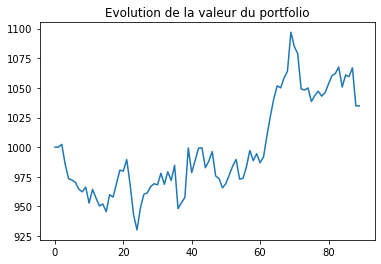

[1000.0,
 1000.0,
 1002.3795695154295,
 985.6883202777702,
 973.342517045734,
 972.2774764077699,
 970.291708665154,
 964.4977538677323,
 962.3421385454269,
 966.3083077345149,
 952.8185890510996,
 964.4092788869,
 957.2465123361085,
 950.4060580999895,
 952.0440627748904,
 945.6219502724186,
 959.9055031711657,
 957.9271772946508,
 969.2484430914953,
 980.6927415428945,
 979.8162982342074,
 989.53498342348,
 968.3630808243838,
 942.9083884195132,
 930.2298414906184,
 948.6070735016747,
 960.265149111232,
 961.4088002351266,
 966.7738796563967,
 969.1697142112198,
 968.2487300696694,
 977.9904704400467,
 968.6773822789373,
 979.2716469382128,
 971.8662135464492,
 984.7054617093493,
 948.1828214826686,
 953.196379885714,
 957.6142768109706,
 999.3719828229871,
 978.5275167606712,
 988.7843187840929,
 999.1535821999622,
 999.446027053227,
 982.6990487928452,
 988.2709900853649,
 996.2764437212905,
 975.7262924586119,
 973.4398867092444,
 965.7421717479475,
 969.3364805432373,
 976.765081

In [23]:
etape1(False)
reste(False)

plt.plot(argent_fait)
plt.title("Evolution de la valeur du portfolio")
plt.show()

argent_fait

Calcul du drawdown

In [29]:
drawdown = -math.inf
maxi = -math.inf
mini = math.inf
i = 0
details = False # afficher plus de détails

for x in argent_fait:
    if x > maxi:
        if details :
            print("max atteint en{}:{}".format(i, argent_fait[i]) )
        maxi = x
        mini = math.inf
    elif x < mini:
        if details:
            print("min atteint en{}:{}".format(i, argent_fait[i]) )
        mini = x
        drawdown = max(drawdown, (maxi-mini)/maxi)
    i+=1

drawdown

0.07197845029871244

In [10]:
pos.round(3)

array([6.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3640e+01,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2542e+01, 0.0000e+00,
       0.0000e+00, 7.3675e+01, 0.0000e+00, 4.7862e+01, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

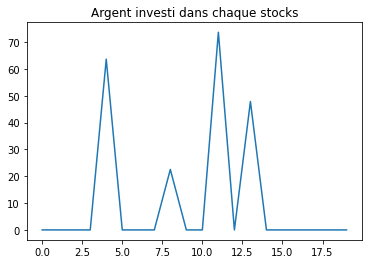

L'argent est le plus investi dans l'action: TLT


In [11]:
plt.plot([pos[i] for i in range(len(pos))])
plt.title("Argent investi dans chaque stocks")
plt.show()
print("L'argent est le plus investi dans l'action: "+symbols[np.argmax(pos)])

In [12]:
# Le returns avec une telle repartition de portefeuille est de:
returns.mean()

SPY      0.000467
QQQ      0.000667
VGK      0.000113
SCZ      0.000192
EWJ      0.000149
EEM      0.000097
REM      0.000209
VNQ      0.000380
RWX      0.000068
TIP      0.000156
IEF      0.000126
TLT      0.000237
BWX     -0.000009
DBC      0.000058
GLD      0.000243
twtr    -0.000324
intc     0.000404
tsm      0.000967
VWUSX    0.000555
Amc      0.000020
dtype: float64

In [13]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([symbols,p.x])
for i in range(len(symbols)):
    print(symbols[i],p.x[i].round(3))

Nombre d'action acheté pour chaque symbols: 


NameError: name 'p' is not defined